In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/__script__.py
/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/__results__.html
/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/input_requirements.txt
/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/__script__.ipynb
/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/__output__.json
/kaggle/input/pm-75859731-at-02-03-2025-12-28-15/custom.css
/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=3c9fd6705c8402332ff5fb911d4686ecd32b5b39466539d4903a202ce3b98677
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import lifelines
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from lifelines.utils import concordance_index
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Reading training and testing files
df_train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [5]:
# Print the first few rows of the training data
print("Training Data:")
print(df_train.head())

Training Data:
   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           NaN       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           NaN       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           NaN       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0               NaN             NaN              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6  ...          tce_div_match donor_related  \
0            6.0  ...            

In [6]:
# Print the shape of the training and testing data
print("\nTraining Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)


Training Data Shape: (28800, 60)
Testing Data Shape: (3, 58)


In [7]:
# Categorical and Numerical Columns
cat_cols = []
num_cols = []

In [8]:
for col in df_train.columns:
    if df_train[col].dtypes == 'object' and col not in ('efs', 'efs_time'):
        cat_cols.append(col)
    elif df_train[col].dtypes != 'object' and col not in ('efs', 'efs_time', 'ID'):
        num_cols.append(col)

In [9]:
print("\nNumber of categorical columns:", len(cat_cols))
print("Number of numerical columns:", len(num_cols))


Number of categorical columns: 35
Number of numerical columns: 22


In [10]:
# Convert categorical columns to 'category' type
for col in df_train.select_dtypes(include='object').columns:
    df_train[col] = df_train[col].astype('category')

for col in df_test.select_dtypes(include='object').columns:
    df_test[col] = df_test[col].astype('category')



In [11]:
# Making Target variable using KaplanMeierFitter (kmf) and NelsonAalenFitter (naf)
kmf = KaplanMeierFitter()
kmf.fit(df_train['efs_time'], df_train['efs'])

df_train['y_kmf'] = kmf.survival_function_at_times(df_train['efs_time']).values
df_train.loc[df_train['efs'] == 0, 'y_kmf'] -= 0.1

In [12]:
# NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(df_train['efs_time'], df_train['efs'])

df_train['y_naf'] = -naf.cumulative_hazard_at_times(df_train['efs_time']).values
df_train.loc[df_train['efs'] == 0, 'y_naf'] -= 0.1

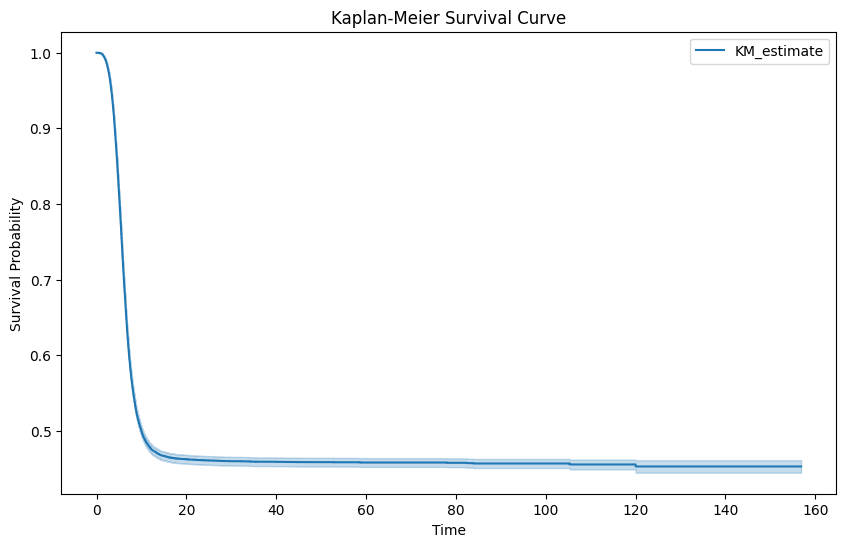

In [13]:
# Plot Kaplan-Meier Survival Curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

In [14]:
# Cross Validations
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Model Parameters
xgb_kmf_final_param = {
    'booster': 'gbtree',
    'enable_categorical': True,
    'learning_rate': 0.02,
    'max_depth': 2,
    'n_estimators': 5000,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'reg_lambda': 0.015
}

xgb_naf_final_param = {
    'booster': 'gbtree',
    'enable_categorical': True,
    'learning_rate': 0.01,
    'max_depth': 2,
    'n_estimators': 10000,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'reg_lambda': 0.1
}

lgbm_final_param_kmf = {
    'max_depth': 2,
    'learning_rate': 0.03,
    'n_estimators': 4000,
    'reg_lambda': 0.001,
    'random_state': 42,
    'verbose': -1
}

lgbm_final_param_naf = {
    'max_depth': 3,
    'learning_rate': 0.03,
    'n_estimators': 2000,
    'reg_lambda': 0.02,
    'random_state': 42,
    'verbose': -1
}

cb_param_kmf = {
    'bootstrap_type': 'Bernoulli',
    'learning_rate': 0.03,
    'num_trees': 8000,
    'subsample': 0.85,
    'reg_lambda': 8.0,
    'depth': 8,
    'verbose': 2000
}

In [16]:
# Cross-Validation Loop
all_preds = []
all_efs = []
all_efs_time = []
scores = []

for i, (train_indexes, val_indexes) in enumerate(kf.split(df_train)):
    train_data = df_train.iloc[train_indexes]
    val_data = df_train.iloc[val_indexes]
    train_data_cb = df_train.iloc[train_indexes]
    val_data_cb = df_train.iloc[val_indexes]

    for col in train_data_cb.select_dtypes(include='category').columns:
        train_data_cb[col] = train_data_cb[col].astype('str')

    for col in val_data_cb.select_dtypes(include='category').columns:
        val_data_cb[col] = val_data_cb[col].astype('str')

    cat_cols = train_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']).select_dtypes(include='category').columns.values.tolist()
    cat_cols_cb = train_data_cb.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']).select_dtypes(include='object').columns.values.tolist()

    xgb_kmf = XGBRegressor(**xgb_kmf_final_param)
    xgb_kmf.fit(train_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), train_data['y_kmf'])

    xgb_naf = XGBRegressor(**xgb_naf_final_param)
    xgb_naf.fit(train_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), train_data['y_naf'])

    lgbm_kmf = lgb.LGBMRegressor(**lgbm_final_param_kmf)
    lgbm_kmf.fit(train_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), train_data['y_kmf'])

    lgbm_naf = lgb.LGBMRegressor(**lgbm_final_param_naf)
    lgbm_naf.fit(train_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), train_data['y_naf'])

    cb_kmf = CatBoostRegressor(**cb_param_kmf)
    cb_kmf.fit(train_data_cb.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), train_data['y_kmf'], cat_features=cat_cols_cb)

    preds_xgb_kmf = xgb_kmf.predict(val_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']))
    preds_xgb_naf = xgb_naf.predict(val_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']))
    preds_lgbm_kmf = lgbm_kmf.predict(val_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']))
    preds_lgbm_naf = lgbm_naf.predict(val_data.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']))
    preds_cb_kmf = cb_kmf.predict(val_data_cb.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']))

    preds = (preds_xgb_kmf + preds_xgb_naf + preds_lgbm_kmf + preds_lgbm_naf + preds_cb_kmf) / 5

    all_preds += list(preds)
    score = concordance_index(val_data['efs_time'], -preds, val_data['efs'])
    scores.append(score)

    print(f'Fold #{i} C-index: {score}')

print("\nMean Concordance index (using XGB & LGBM):", sum(scores) / len(scores))

0:	learn: 0.2163401	total: 217ms	remaining: 28m 59s
2000:	learn: 0.1557444	total: 5m 1s	remaining: 15m 5s
4000:	learn: 0.1285597	total: 10m 7s	remaining: 10m 6s
6000:	learn: 0.1063466	total: 15m 15s	remaining: 5m 4s
7999:	learn: 0.0885401	total: 20m 23s	remaining: 0us
Fold #0 C-index: 0.6927430162651337
0:	learn: 0.2157997	total: 141ms	remaining: 18m 50s
2000:	learn: 0.1545663	total: 4m 59s	remaining: 14m 56s
4000:	learn: 0.1266179	total: 10m 8s	remaining: 10m 8s
6000:	learn: 0.1044971	total: 15m 17s	remaining: 5m 5s
7999:	learn: 0.0870146	total: 20m 25s	remaining: 0us
Fold #1 C-index: 0.6902903499860925
0:	learn: 0.2164439	total: 140ms	remaining: 18m 43s
2000:	learn: 0.1546654	total: 4m 57s	remaining: 14m 52s
4000:	learn: 0.1275951	total: 10m 5s	remaining: 10m 5s
6000:	learn: 0.1055190	total: 15m 16s	remaining: 5m 5s
7999:	learn: 0.0872556	total: 20m 28s	remaining: 0us
Fold #2 C-index: 0.6923251275900073
0:	learn: 0.2160424	total: 142ms	remaining: 18m 56s
2000:	learn: 0.1528426	total:

In [17]:
# Final Prediction
xgb_kmf = XGBRegressor(**xgb_kmf_final_param)
xgb_kmf.fit(df_train.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), df_train['y_kmf'])

xgb_naf = XGBRegressor(**xgb_naf_final_param)
xgb_naf.fit(df_train.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), df_train['y_naf'])

lgbm_kmf = lgb.LGBMRegressor(**lgbm_final_param_kmf)
lgbm_kmf.fit(df_train.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), df_train['y_kmf'])

lgbm_naf = lgb.LGBMRegressor(**lgbm_final_param_naf)
lgbm_naf.fit(df_train.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), df_train['y_naf'])

X_train_cb = df_train.copy()
for col in X_train_cb.select_dtypes(include='category').columns:
    X_train_cb[col] = X_train_cb[col].astype('str')

X_test_cb = df_test.copy()
for col in X_test_cb.select_dtypes(include='category').columns:
    X_test_cb[col] = X_test_cb[col].astype('str')

cat_cols_cb = X_train_cb.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']).select_dtypes(include='object').columns.values.tolist()

cb_kmf = CatBoostRegressor(**cb_param_kmf)
cb_kmf.fit(X_train_cb.drop(columns=['ID', 'efs', 'efs_time', 'y_kmf', 'y_naf']), X_train_cb['y_kmf'], cat_features=cat_cols_cb)


0:	learn: 0.2162603	total: 102ms	remaining: 13m 38s
2000:	learn: 0.1588496	total: 5m 48s	remaining: 17m 23s
4000:	learn: 0.1347857	total: 11m 42s	remaining: 11m 42s
6000:	learn: 0.1150243	total: 17m 38s	remaining: 5m 52s
7999:	learn: 0.0986913	total: 23m 34s	remaining: 0us


In [18]:
preds_xgb_kmf = xgb_kmf.predict(df_test.drop(columns=['ID']))
preds_xgb_naf = xgb_naf.predict(df_test.drop(columns=['ID']))
preds_lgbm_kmf = lgbm_kmf.predict(df_test.drop(columns=['ID']))
preds_lgbm_naf = lgbm_naf.predict(df_test.drop(columns=['ID']))
preds_cb_kmf = cb_kmf.predict(X_test_cb.drop(columns=['ID']))

final_prediction = (preds_xgb_kmf + preds_xgb_naf + preds_lgbm_kmf + preds_lgbm_naf + preds_cb_kmf) / 5

In [19]:
df_test['prediction'] = final_prediction



In [20]:
sub = df_test[['ID', 'prediction']]
sub.to_csv('submission.csv', index=False)
sub.to_csv('/kaggle/working/submission.csv', index=False)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,-0.065745
1,28801,0.224319
2,28802,-0.147253


In [21]:
# Final Report
print("\nFinal Report:")
print("Mean Concordance index (C-index):", sum(scores) / len(scores))
print("\nSubmission Data:")
print(sub.head())


Final Report:
Mean Concordance index (C-index): 0.6881365636381989

Submission Data:
      ID  prediction
0  28800   -0.065745
1  28801    0.224319
2  28802   -0.147253
